In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [ ]:
!pip install -q mlflow
!pip install -q python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [ ]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [ ]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [ ]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2023.pkl'))

In [ ]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,2,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,3,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,4,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,5,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [ ]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [ ]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [ ]:
df = pipe_clean.fit_transform(df)

In [ ]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
2,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
3,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
4,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
5,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [ ]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.20598116428925484

In [ ]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [ ]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [ ]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [ ]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [ ]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [ ]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [ ]:
mlflow.set_experiment('XGBoost')

2023/11/10 23:41:13 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/4', creation_time=1699659673981, experiment_id='4', last_update_time=1699659673981, lifecycle_stage='active', name='XGBoost', tags={}>

In [ ]:
param_grid = {
    'max_depth': [3],
    'colsample_bytree': [.7],
    'subsample': [.7],
    'n_estimators': [150],
    'learning_rate': [.2]
    }

In [ ]:
with mlflow.start_run():
    estimator = xgb.XGBRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_xgb(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_xgb(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   5.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   8.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   5.0s
[CV] END colsample_

In [ ]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.012744,0.014506,0.029871
R2,0.993339,0.977279,0.714021


In [ ]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [ ]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.501662
173,2017,James Harden,0.746,0.634808
261,2017,Kawhi Leonard,0.495,0.467288
221,2017,LeBron James,0.330,0.345739
425,2017,Isaiah Thomas,0.080,0.194055
98,2017,Stephen Curry,0.051,0.210624
16,2017,Giannis Antetokounmpo,0.007,0.152289
453,2017,John Wall,0.007,0.072759
100,2017,Anthony Davis,0.002,0.052682


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.950929
249,2018,LeBron James,0.731,0.512729
122,2018,Anthony Davis,0.441,0.254331
298,2018,Damian Lillard,0.205,0.139613
508,2018,Russell Westbrook,0.075,0.238726
16,2018,Giannis Antetokounmpo,0.074,0.130892
143,2018,Kevin Durant,0.065,0.177132
130,2018,DeMar DeRozan,0.032,0.001558
7,2018,LaMarcus Aldridge,0.006,0.025871


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.710907
207,2019,James Harden,0.768,0.566548
184,2019,Paul George,0.352,0.101857
270,2019,Nikola Jokić,0.210,0.138337
124,2019,Stephen Curry,0.173,0.095550
305,2019,Damian Lillard,0.068,0.157152
155,2019,Joel Embiid,0.049,0.090968
150,2019,Kevin Durant,0.025,0.119154
301,2019,Kawhi Leonard,0.013,0.246523


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.733480
251,2020,LeBron James,0.746,0.514225
199,2020,James Harden,0.363,0.352640
134,2020,Luka Dončić,0.198,0.137621
294,2020,Kawhi Leonard,0.166,0.115659
123,2020,Anthony Davis,0.081,0.336616
396,2020,Chris Paul,0.026,-0.012056
297,2020,Damian Lillard,0.023,0.011865
262,2020,Nikola Jokić,0.018,0.052974


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.399933
146,2021,Joel Embiid,0.580,0.044327
116,2021,Stephen Curry,0.449,0.188238
12,2021,Giannis Antetokounmpo,0.345,0.397793
396,2021,Chris Paul,0.138,-0.026493
130,2021,Luka Dončić,0.042,0.266800
297,2021,Damian Lillard,0.038,0.136764
421,2021,Julius Randle,0.020,-0.002491
439,2021,Derrick Rose,0.010,-0.000281


,,Player,Share,PredShare
Rk,Season,,,
290,2022,Nikola Jokić,0.875,0.339557
162,2022,Joel Embiid,0.706,0.306988
12,2022,Giannis Antetokounmpo,0.595,0.318273
59,2022,Devin Booker,0.216,0.087358
141,2022,Luka Dončić,0.146,0.352836
526,2022,Jayson Tatum,0.043,0.138543
390,2022,Ja Morant,0.010,0.168049
126,2022,Stephen Curry,0.004,0.038142
438,2022,Chris Paul,0.002,0.037133


,,Player,Share,PredShare
Rk,Season,,,
143,2023,Joel Embiid,0.915,0.466233
249,2023,Nikola Jokić,0.674,0.624207
11,2023,Giannis Antetokounmpo,0.606,0.344469
465,2023,Jayson Tatum,0.280,0.282294
164,2023,Shai Gilgeous-Alexander,0.046,0.175151
338,2023,Donovan Mitchell,0.030,0.082472
428,2023,Domantas Sabonis,0.027,0.163820
125,2023,Luka Dončić,0.010,0.169128
108,2023,Stephen Curry,0.005,-0.008978


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2017,Álex Abrines,0.0,0.000202
2,2017,Quincy Acy,0.0,0.000223
4,2017,Arron Afflalo,0.0,0.000074
5,2017,Alexis Ajinça,0.0,0.000687
6,2017,Cole Aldrich,0.0,0.001045
...,...,...,...,...
526,2023,Ziaire Williams,0.0,0.000327
527,2023,Zion Williamson,0.0,0.019912
532,2023,Delon Wright,0.0,0.000788


In [ ]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
156,2017,Rudy Gobert,0.0,0.174355
351,2017,Chris Paul,0.0,0.106687
151,2019,Trevon Duval,0.0,0.141169
35,2020,Bradley Beal,0.0,0.129456
405,2020,Shamorie Ponds,0.0,0.208141
38,2021,Bradley Beal,0.0,0.154733
190,2023,James Harden,0.0,0.164179


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

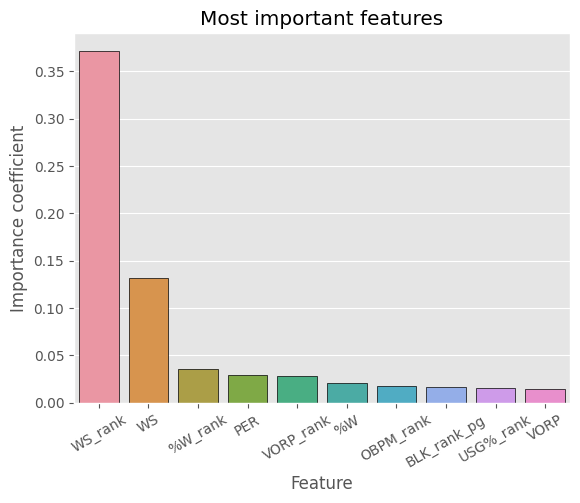

In [ ]:
mod.display_feature_importances_xgb(best_model)

In [ ]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

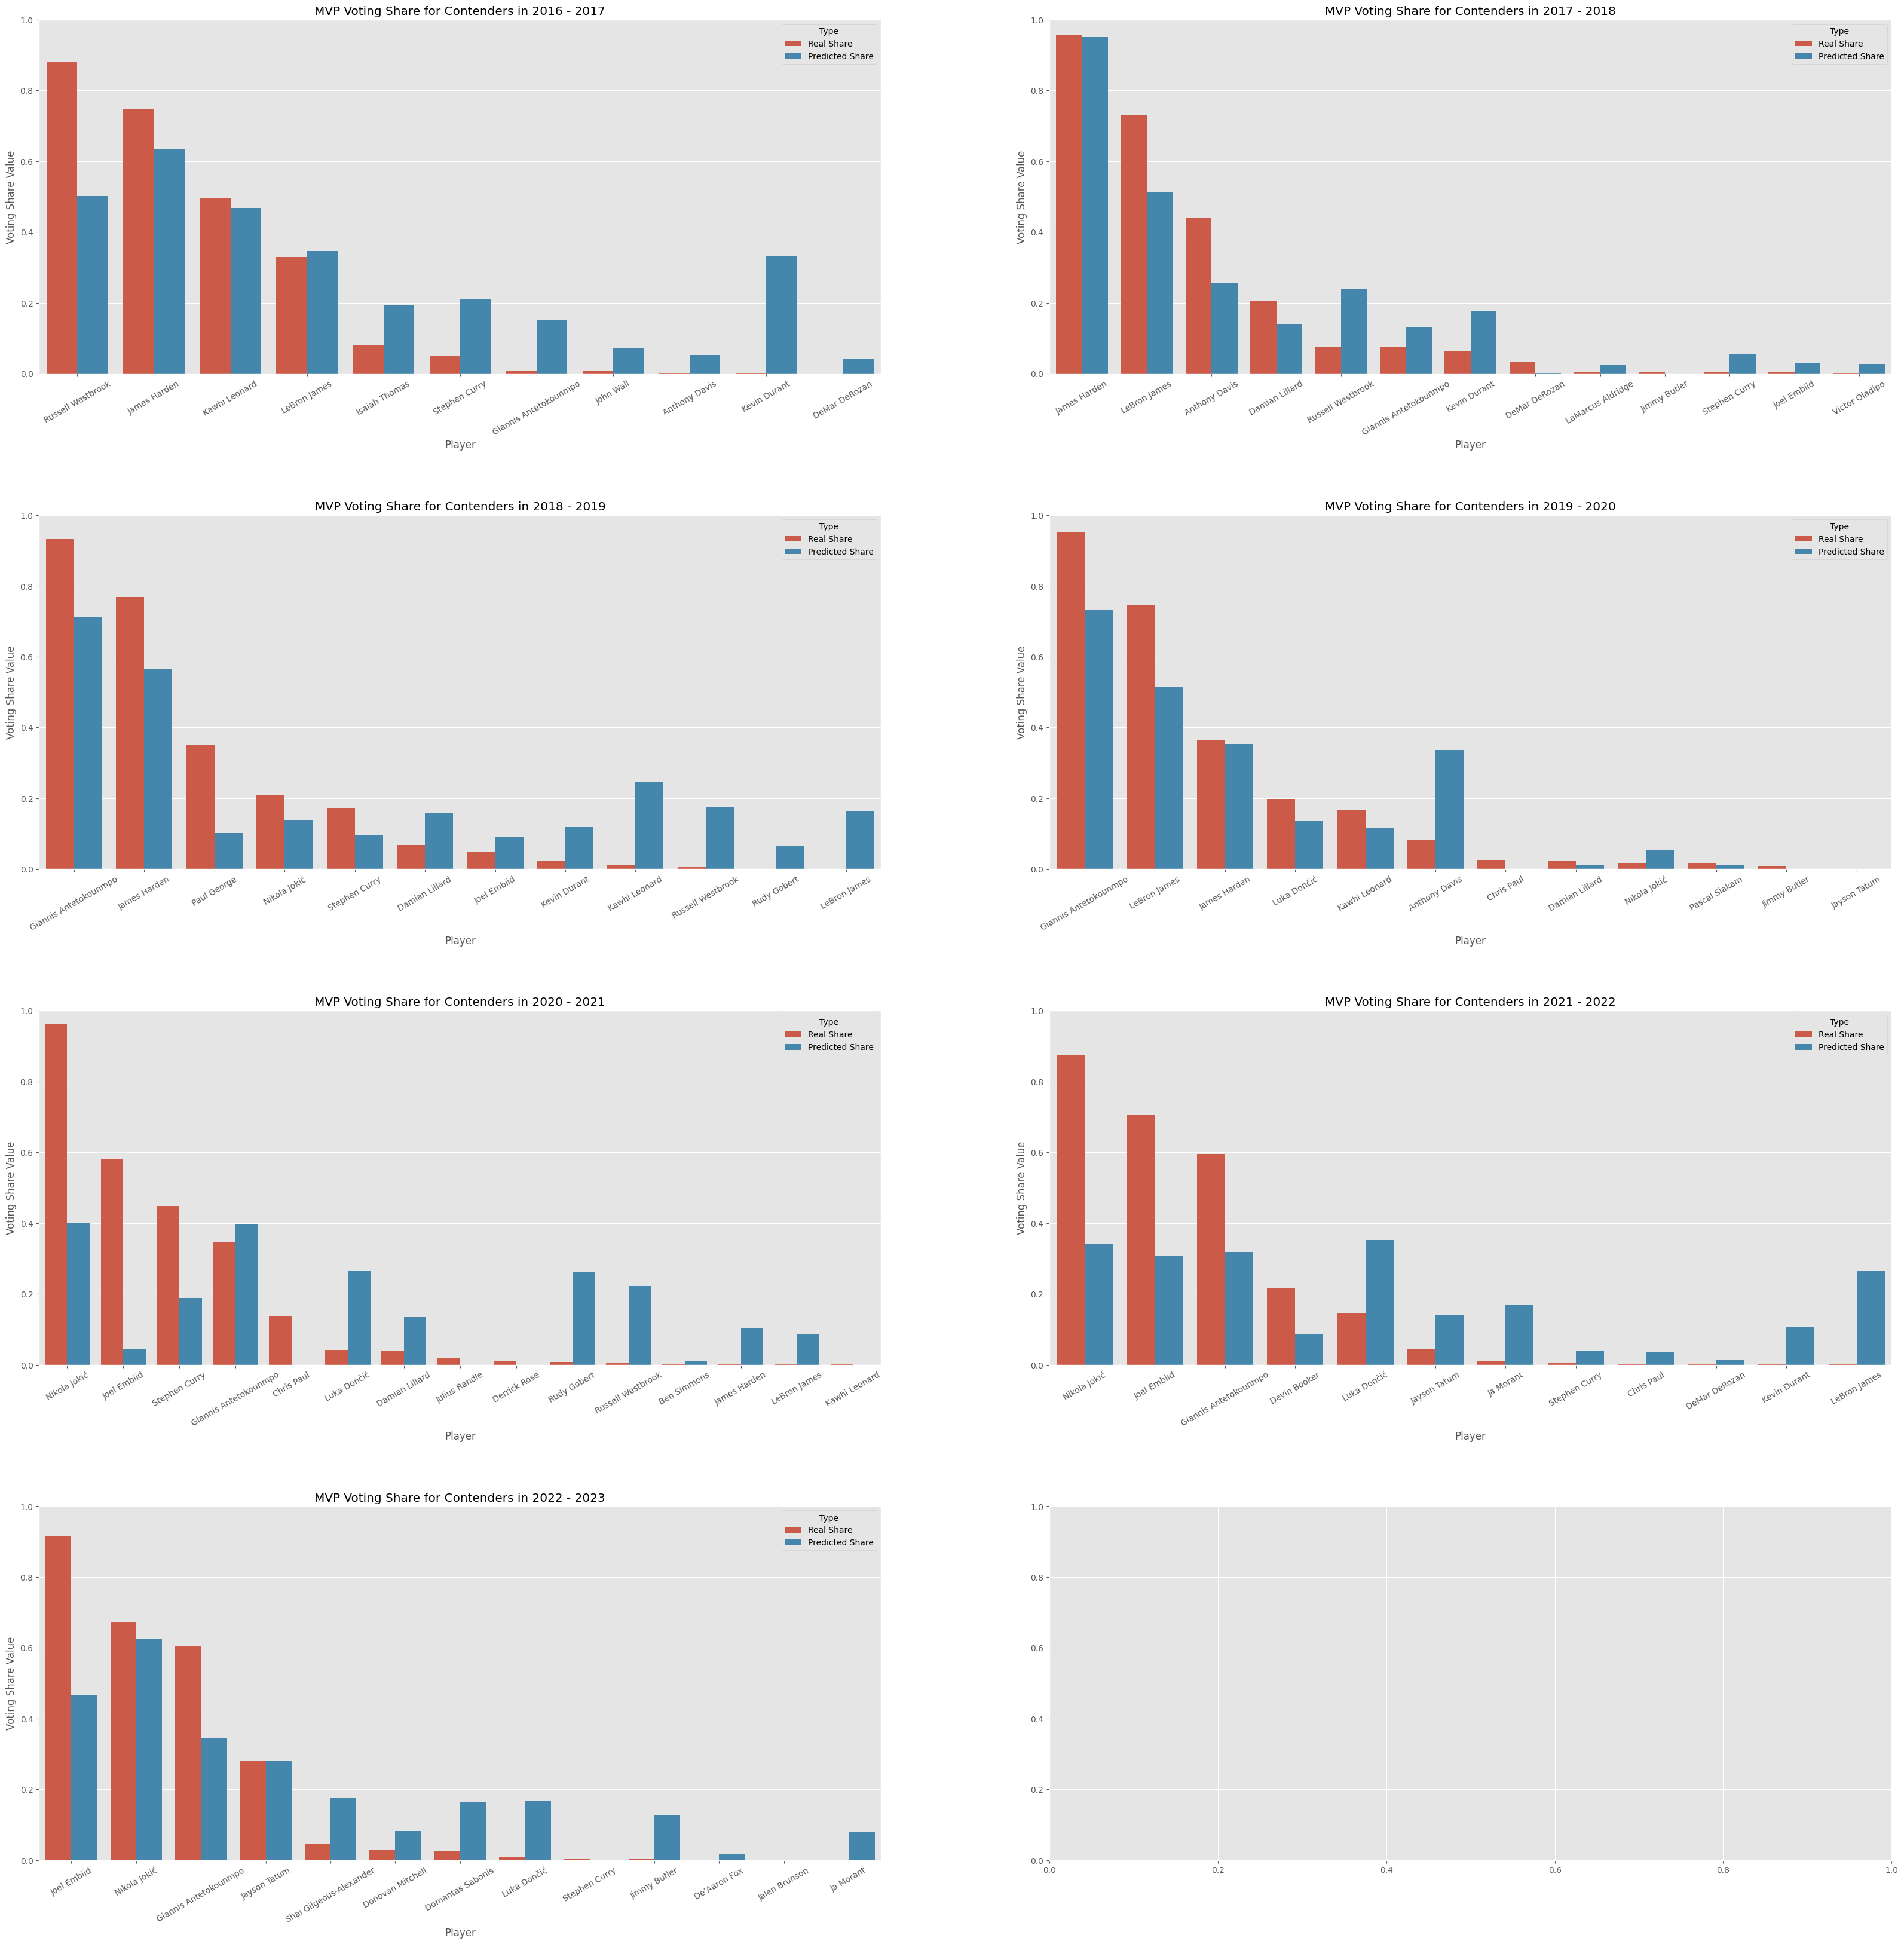

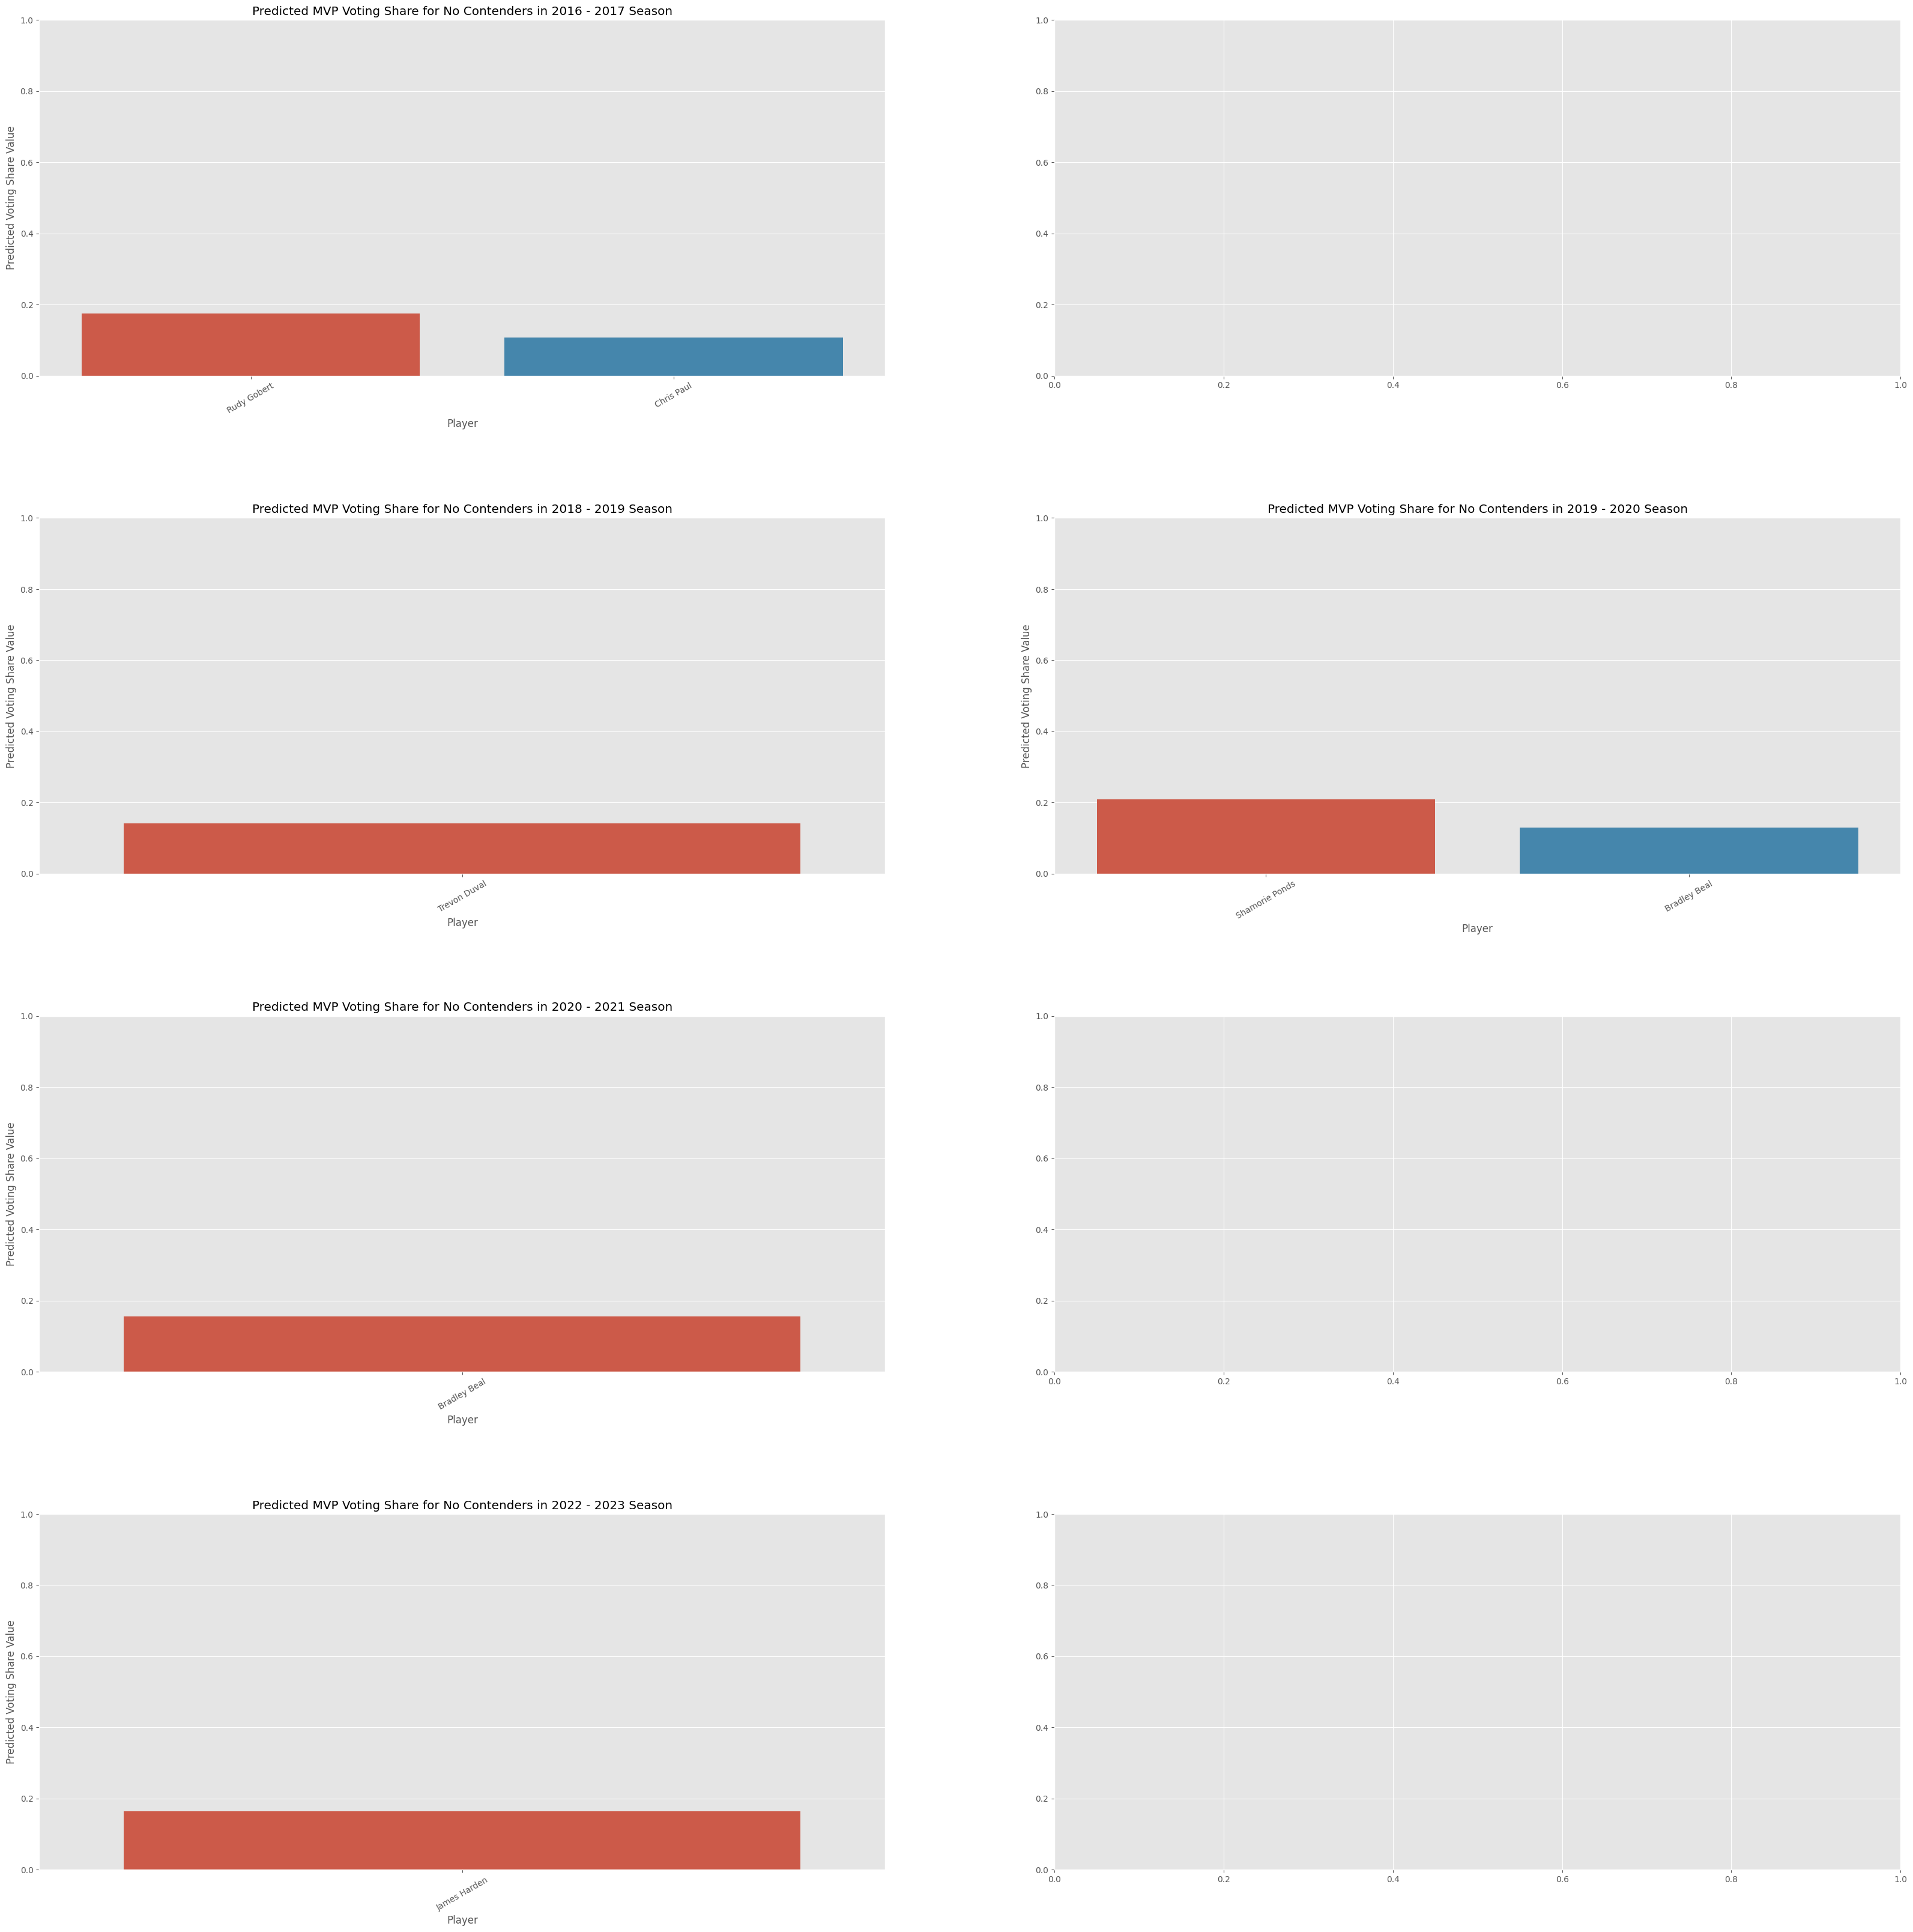

In [ ]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)